In [1]:
# !pip install gensim
# !pip install tensorflow
# import nltk
# nltk.download('punkt_tab')

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from transformers import TrainingArguments, Trainer, RobertaTokenizer, RobertaForSequenceClassification, DistilBertTokenizerFast, DistilBertForSequenceClassification

In [3]:
train = pd.read_csv('../../data/yelp/train_en.txt', sep='\t')
test = pd.read_csv('../../data/yelp/test_en.txt', sep='\t')
val = pd.read_csv('../../data/yelp/val_en.txt', sep='\t')

In [4]:
print(f"Train samples: {len(train)}")
print(f"Validation samples: {len(val)}")
print(f"Test samples: {len(test)}")

Train samples: 342905
Validation samples: 42863
Test samples: 42864


In [5]:
train.head()

,Sentence,Style,User
0,Cute interior and owner (?) gave us tour of up...,positive,bcjbaE6dDog4jkNY91ncLQ
1,I've been to this location many times when I l...,negative,enaHB1e956thdnafcHVAig
2,My food only merited maybe two stars but I wil...,negative,07aVWNhBhpwqW3MdqoKDKQ
3,After trying a few ramen places with crazy var...,negative,OkjeFppodgJP_CvB84cJYw
4,I cannot even believe someone gave this place ...,positive,7Ie0VmQtnGYUVq2YW4dTVw


In [6]:
labels_train = train['Style'].values
labels_val = val['Style'].values
labels_test = test['Style'].values

In [7]:
LE = LabelEncoder()
LE.fit(labels_train)

LabelEncoder()

In [8]:
y_train = LE.transform(labels_train)
y_val =  LE.transform(labels_val)
y_test = LE.transform(labels_test)
y_train

array([1, 0, 0, ..., 0, 1, 1], shape=(342905,))

In [9]:
print(f"Label distribution in train:\n{train['Style'].value_counts()}")

Label distribution in train:
Style
positive    246823
negative     96082
Name: count, dtype: int64


##### RoBERTa

In [10]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [14]:
train_lengths = [len(roberta_tokenizer.encode(text)) for text in train['Sentence']]

In [17]:
truncated = sum(1 for length in train_lengths if length > 128)
print(f"\nPercentage of truncated sentences if maximum length is 128: {truncated / len(train_lengths) * 100:.2f}%")

truncated_256 = sum(1 for length in train_lengths if length > 256)
print(f"Percentage of truncated sentences if maximum length is 256: {truncated_256/len(train_lengths)*100:.2f}%")


Percentage of truncated sentences if maximum length is 128: 61.16%
Percentage of truncated sentences if maximum length is 256: 0.07%


In [19]:
train_encodings_roberta = roberta_tokenizer(
    train['Sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

val_encodings_roberta = roberta_tokenizer(
    val['Sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

test_encodings_roberta = roberta_tokenizer(
    test['Sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [20]:
print(f"Input IDs shape: {train_encodings_roberta['input_ids'].shape}")
print(f"Attention mask shape: {train_encodings_roberta['attention_mask'].shape}")

Input IDs shape: torch.Size([342905, 128])
Attention mask shape: torch.Size([342905, 128])


In [21]:
class RobertaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
train_dataset_roberta = RobertaDataset(train_encodings_roberta, y_train.tolist())
val_dataset_roberta = RobertaDataset(val_encodings_roberta, y_val.tolist())
test_dataset_roberta = RobertaDataset(test_encodings_roberta, y_test.tolist())

In [23]:
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    learning_rate=0.00002,
    weight_decay=0.01,
    eval_strategy='epoch',
    report_to='none',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
trainer_roberta = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    processing_class=roberta_tokenizer
)

In [25]:
history_roberta = trainer_roberta.train()

Epoch,Training Loss,Validation Loss
1,0.212500,0.209382
2,0.179300,0.216807
3,0.138700,0.235480


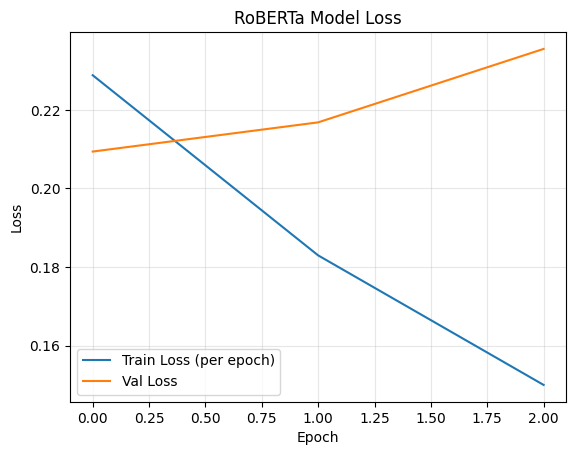

In [59]:
log_history = trainer_roberta.state.log_history

train_losses_steps = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

num_epochs = len(eval_losses)

train_losses_epoch = []
chunk = len(train_losses_steps) // num_epochs
for i in range(num_epochs):
    start = i * chunk
    end = (i + 1) * chunk
    train_losses_epoch.append(sum(train_losses_steps[start:end]) / chunk)

plt.plot(train_losses_epoch, label='Train Loss (per epoch)')
plt.plot(eval_losses, label='Val Loss')
plt.title('RoBERTa Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [27]:
predictions_roberta = trainer_roberta.predict(test_dataset_roberta)
pred_roberta = predictions_roberta.predictions.argmax(-1)
test_labels = y_test

In [28]:
print(f'Accuracy: {accuracy_score(test_labels, pred_roberta)}')
print(f'Precision: {precision_score(test_labels, pred_roberta)}')
print(f'Recall: {recall_score(test_labels, pred_roberta)}')
print(f'F1-score: {f1_score(test_labels, pred_roberta)}')

Accuracy: 0.9220091452034341
Precision: 0.935670847586469
Recall: 0.9574757722101579
F1-score: 0.9464477372847417


In [60]:
first_result = {
    'config': {'lr': 0.00002, 'epochs': 3, 'weight_decay': 0.01, 'batch_size': 32, 'name': 'baseline'},
    'accuracy': accuracy_score(y_test, pred_roberta),
    'precision': precision_score(y_test, pred_roberta),
    'recall': recall_score(y_test, pred_roberta),
    'f1': f1_score(y_test, pred_roberta),
    'history': history_roberta,
    'log_history': trainer_roberta.state.log_history
}

In [30]:
configs = [
    {'lr': 0.001, 'epochs': 3, 'weight_decay': 0.01, 'batch_size': 32, 'name': 'high_lr'},
    {'lr': 0.00002, 'epochs': 3, 'weight_decay': 0.005, 'batch_size': 32, 'name': 'lower_wd'},
    {'lr': 0.00002, 'epochs': 5, 'weight_decay': 0.01, 'batch_size': 32, 'name': 'more_epochs'},
]

In [31]:
results = [first_result]

for config in configs:
    print(f"\nTraining with: LR={config['lr']}, Epochs={config['epochs']}, WD={config['weight_decay']}")

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

    training_args = TrainingArguments(
        output_dir=f'./results_roberta_{config["name"]}',
        num_train_epochs=config['epochs'],
        learning_rate=config['lr'],
        weight_decay=config['weight_decay'],
        eval_strategy='epoch',
        report_to='none',
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_roberta,
        eval_dataset=val_dataset_roberta,
        processing_class=roberta_tokenizer
    )

    history = trainer.train()

    predictions = trainer.predict(test_dataset_roberta)
    pred = predictions.predictions.argmax(-1)

    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    results.append({
        'config': config,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'history': history
    })



Training with: LR=0.001, Epochs=3, WD=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.597200,0.595117
2,0.595700,0.593281
3,0.591300,0.593095



Training with: LR=2e-05, Epochs=3, WD=0.005


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.213800,0.216703
2,0.178300,0.218739
3,0.140100,0.236886



Training with: LR=2e-05, Epochs=5, WD=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.215400,0.208705
2,0.184900,0.213705
3,0.153100,0.232913
4,0.120000,0.286687
5,0.103200,0.329613


In [32]:
results_df = pd.DataFrame([
    {
        'Config': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'Weight Decay': r['config']['weight_decay'],
        'Batch Size': r['config']['batch_size'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}"
    }
    for r in results
])

print(results_df.to_string(index=False))

     Config  Learning Rate  Epochs  Weight Decay  Batch Size Accuracy Precision Recall F1-Score
   baseline        0.00002       3         0.010          32   0.9220    0.9357 0.9575   0.9464
    high_lr        0.00100       3         0.010          32   0.7198    0.7198 1.0000   0.8371
   lower_wd        0.00002       3         0.005          32   0.9220    0.9361 0.9569   0.9464
more_epochs        0.00002       5         0.010          32   0.9163    0.9359 0.9488   0.9423


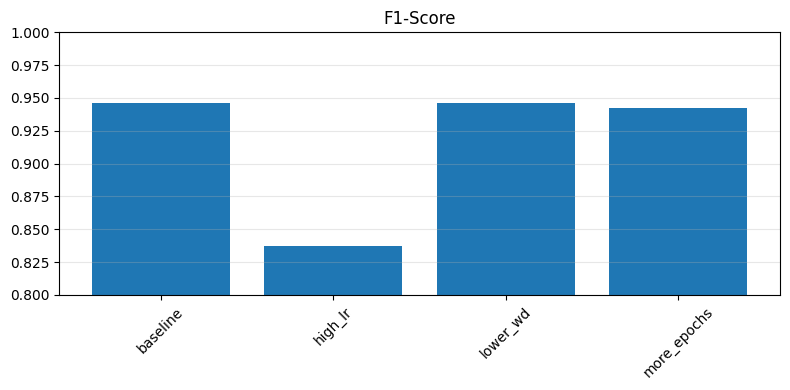

In [63]:
configs_names = [r['config']['name'] for r in results]
f1_scores_tuning = [r['f1'] for r in results]

plt.figure(figsize=(8,4))
plt.bar(configs_names, f1_scores_tuning)
plt.title('F1-Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.80, 1)

plt.tight_layout()
plt.show()

In [34]:
best_model = max(results, key=lambda x: x['f1'])
print(f"Config: {best_model['config']['name']}")
print(f"Learning Rate: {best_model['config']['lr']}")
print(f"Epochs: {best_model['config']['epochs']}")
print(f"Weight Decay: {best_model['config']['weight_decay']}")
print(f"Batch Size: {best_model['config']['batch_size']}")
print(f"F1-Score: {best_model['f1']:.4f}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

Config: baseline
Learning Rate: 2e-05
Epochs: 3
Weight Decay: 0.01
Batch Size: 32
F1-Score: 0.9464
Accuracy: 0.9220


##### DistilBERT

In [64]:
distil_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [38]:
train_encodings_distil = distil_tokenizer(
    train['Sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

val_encodings_distil = distil_tokenizer(
    val['Sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

test_encodings_distil = distil_tokenizer(
    test['Sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [39]:
print(f"Input IDs shape (Distil): {train_encodings_distil['input_ids'].shape}")

Input IDs shape (Distil): torch.Size([342905, 128])


In [40]:
class DistilDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [41]:
train_dataset_distil = DistilDataset(train_encodings_distil, y_train.tolist())
val_dataset_distil = DistilDataset(val_encodings_distil, y_val.tolist())
test_dataset_distil = DistilDataset(test_encodings_distil, y_test.tolist())

In [42]:
distil_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args_distil = TrainingArguments(
    output_dir='./results_distil',
    num_train_epochs=3,
    learning_rate=0.00002,
    weight_decay=0.01,
    eval_strategy='epoch',
    report_to='none',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
trainer_distil = Trainer(
    model=distil_model,
    args=training_args_distil,
    train_dataset=train_dataset_distil,
    eval_dataset=val_dataset_distil,
    processing_class=distil_tokenizer
)

In [44]:
history_distil = trainer_distil.train()

Epoch,Training Loss,Validation Loss
1,0.231400,0.224884
2,0.183300,0.226570
3,0.143100,0.252554


In [45]:
predictions_distil = trainer_distil.predict(test_dataset_distil)
pred_distil = predictions_distil.predictions.argmax(-1)

acc_distil = accuracy_score(y_test, pred_distil)
prec_distil = precision_score(y_test, pred_distil)
rec_distil = recall_score(y_test, pred_distil)
f1_distil = f1_score(y_test, pred_distil)

In [46]:
first_distil_result = {
    'config': {'lr': 0.00002, 'epochs': 3, 'weight_decay': 0.01, 'batch_size': 32, 'name': 'baseline_distil'},
    'accuracy': acc_distil,
    'precision': prec_distil,
    'recall': rec_distil,
    'f1': f1_distil,
    'history': history_distil,
    'log_history': trainer_distil.state.log_history
}

In [47]:
configs_distil = [
    {'lr': 0.01, 'epochs': 3, 'weight_decay': 0.01, 'batch_size': 32, 'name': 'high_lr_distil'},
    {'lr': 0.00002, 'epochs': 3, 'weight_decay': 0.005, 'batch_size': 32, 'name': 'lower_wd_distil'},
    {'lr': 0.00002, 'epochs': 5, 'weight_decay': 0.01, 'batch_size': 32, 'name': 'more_epochs_distil'},
]

In [48]:
results_distil = [first_distil_result]

for config in configs_distil:
    print(f"\nTraining DistilBERT with: LR={config['lr']}, Epochs={config['epochs']}, WD={config['weight_decay']}")
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    training_args = TrainingArguments(
        output_dir=f'./results_distil_{config["name"]}',
        num_train_epochs=config['epochs'],
        learning_rate=config['lr'],
        weight_decay=config['weight_decay'],
        eval_strategy='epoch',
        report_to='none',
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_distil,
        eval_dataset=val_dataset_distil,
        tokenizer=distil_tokenizer
    )

    history = trainer.train()

    predictions = trainer.predict(test_dataset_distil)
    pred = predictions.predictions.argmax(-1)

    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    results_distil.append({
        'config': config,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'history': history,
        'log_history': trainer.state.log_history
    })


Training DistilBERT with: LR=0.01, Epochs=3, WD=0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ajana\AppData\Local\Temp\ipykernel_24872\3232503109.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.218100,0.593153
2,0.442000,0.593153
3,0.276700,0.593153



Training DistilBERT with: LR=2e-05, Epochs=3, WD=0.005


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ajana\AppData\Local\Temp\ipykernel_24872\3232503109.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.231300,0.224838
2,0.182500,0.231085
3,0.143600,0.255433



Training DistilBERT with: LR=2e-05, Epochs=5, WD=0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ajana\AppData\Local\Temp\ipykernel_24872\3232503109.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.232400,0.225568
2,0.187500,0.233846
3,0.149600,0.247629
4,0.114000,0.326345
5,0.090200,0.363860


In [49]:
results_distil_df = pd.DataFrame([
    {
        'Config': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'Weight Decay': r['config']['weight_decay'],
        'Batch Size': r['config']['batch_size'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}"
    }
    for r in results_distil
])

In [51]:
best_model_distil = max(results_distil, key=lambda x: x['f1'])
print(f"Config: {best_model_distil['config']['name']}")
print(f"Learning Rate: {best_model_distil['config']['lr']}")
print(f"Epochs: {best_model_distil['config']['epochs']}")
print(f"Weight Decay: {best_model_distil['config']['weight_decay']}")
print(f"Batch Size: {best_model_distil['config']['batch_size']}")
print(f"F1-Score: {best_model_distil['f1']:.4f}")
print(f"Accuracy: {best_model_distil['accuracy']:.4f}")

Config: baseline_distil
Learning Rate: 2e-05
Epochs: 3
Weight Decay: 0.01
Batch Size: 32
F1-Score: 0.9401
Accuracy: 0.9126


In [52]:
compare_rows = [{
    'Model': 'RoBERTa_best',
    'Accuracy': best_model['accuracy'],
    'Precision': best_model['precision'],
    'Recall': best_model['recall'],
    'F1': best_model['f1']
}, {
    'Model': 'DistilBERT_best',
    'Accuracy': best_model_distil['accuracy'],
    'Precision': best_model_distil['precision'],
    'Recall': best_model_distil['recall'],
    'F1': best_model_distil['f1']
}, {
    'Model': 'LSTM_best',
    'Accuracy': 0.9001,
    'Precision': 0.9050,
    'Recall': 0.9623,
    'F1': 0.9328
}]

compare_df = pd.DataFrame(compare_rows)
print("\nSummary comparison: ")
print(compare_df.to_string(index=False))


Summary comparison: 
          Model  Accuracy  Precision   Recall       F1
   RoBERTa_best  0.922009   0.935671 0.957476 0.946448
DistilBERT_best  0.912631   0.928571 0.951836 0.940060
      LSTM_best  0.900100   0.905000 0.962300 0.932800


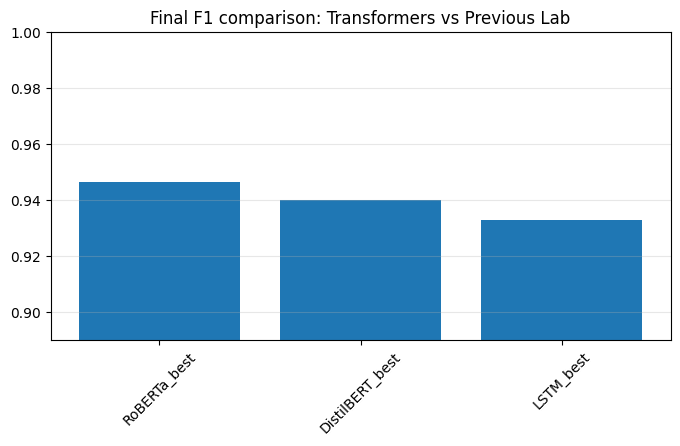

In [57]:
plt.figure(figsize=(8,4))
plt.bar(compare_df['Model'], compare_df['F1'])
plt.title('Final F1 comparison: Transformers vs Previous Lab')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.89, 1)
plt.show()

##### Conclusion:

The results showed that RoBERTa achieves the best overall performance, outperforming both DistilBERT and the LSTM baseline from the previous lab. This represents an improvement over LSTM, confirming the superiority of transformer architectures for sentiment classification tasks. During hyperparameter tuning, we saw that learning rate is a critical parameter because it caused significant drop in the scores, meaning that overly aggressive learning destabilizes the training process. Both transformer models showed fast convergence with just 3 epochs, suggesting efficient learning. DistilBERT showed an excellent compromise between performance and computational efficiency, achieving nearly identical results to RoBERTa while being smaller and faster to train. All three models achieved over 90% accuracy, the Yelp dataset is great for sentiment classification.